In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data\SMSSpamCollection_cleaned.csv')

In [3]:
df.head()

,message,flag
0,go jurong point crazy Available bugis n great ...,ham
1,ok lar joke wif u oni,ham
2,free entry wkly comp win FA Cup final tkts st ...,spam
3,U dun say early hor u c already say,ham
4,nah do nt think go usf live around though,ham


In [4]:
# convert flag column into dummy variable
df = pd.get_dummies(df, columns=['flag'], drop_first=True)

df.head()

,message,flag_spam
0,go jurong point crazy Available bugis n great ...,0
1,ok lar joke wif u oni,0
2,free entry wkly comp win FA Cup final tkts st ...,1
3,U dun say early hor u c already say,0
4,nah do nt think go usf live around though,0


In [5]:
df.isnull().sum()

message      4
flag_spam    0
dtype: int64

There are empty messages in the dataset so we need to drop the rows.

In [6]:
df.dropna(inplace=True)

df.isnull().sum()

message      0
flag_spam    0
dtype: int64

In [8]:
df.flag_spam.value_counts()

0    4495
1     613
Name: flag_spam, dtype: int64

There is a class imbalance here, with only 12% of total messages being spam.

We need to convert messages into vectors using CountVectorizer, with each vector containing an array of token counts.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Create vectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit(df['message'])

X_transform = X.transform(df['message'])

print(X_transform)

  (0, 216)	1
  (0, 404)	1
  (0, 799)	1
  (0, 801)	1
  (0, 1066)	1
  (0, 1303)	1
  (0, 2350)	1
  (0, 2397)	1
  (0, 2479)	1
  (0, 3170)	1
  (0, 3304)	1
  (0, 4660)	1
  (0, 6788)	1
  (0, 7004)	1
  (1, 3133)	1
  (1, 3333)	1
  (1, 4267)	1
  (1, 4300)	1
  (1, 6909)	1
  (2, 298)	1
  (2, 1161)	1
  (2, 1350)	1
  (2, 1864)	2
  (2, 1979)	2
  (2, 2079)	1
  :	:
  (5106, 828)	1
  (5106, 1561)	1
  (5106, 1817)	1
  (5106, 2168)	1
  (5106, 2206)	1
  (5106, 2314)	1
  (5106, 2535)	1
  (5106, 2620)	1
  (5106, 2865)	1
  (5106, 2918)	1
  (5106, 2987)	1
  (5106, 3037)	1
  (5106, 3425)	1
  (5106, 4082)	1
  (5106, 5657)	1
  (5106, 5666)	1
  (5106, 6192)	1
  (5106, 6315)	1
  (5106, 6615)	1
  (5106, 6834)	1
  (5107, 3054)	2
  (5107, 4012)	1
  (5107, 5173)	1
  (5107, 6315)	1
  (5107, 6437)	1


After applying CountVectorizer, we will use TF-IDF to find out how relevant a word is to each message in the dataset. 

The value of TF-IDF increases proportionally to the number of times a word appears in the message, and is offset by the frequency of the word in the collection.

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(X_transform)

In [11]:
# transform entire bag of words corpus into TF-IDF corpus
X_tfidf = tfidf_transformer.transform(X_transform)
print(X_tfidf.shape)

(5108, 7234)


Now we have transformed our messages into vectors, we can start training our classifier. We will use SVM for modeling purpose.

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1579
           1       0.25      0.00      0.01       209

    accuracy                           0.88      1788
   macro avg       0.57      0.50      0.47      1788
weighted avg       0.81      0.88      0.83      1788

Accuracy = 0.88
Recall = 0.00
Precision = 0.25


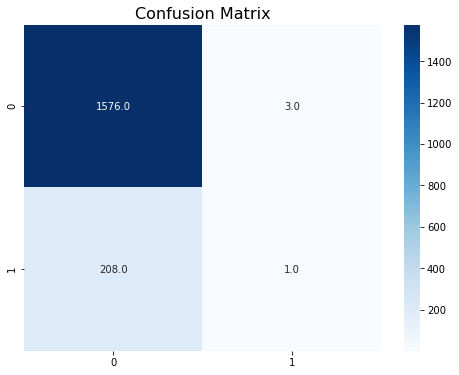

In [12]:
# train-test split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['flag_spam'], test_size=0.35, random_state=42
)

#Train
svc = SVC(kernel='linear').fit(X_train, y_train)
preds = svc.predict(X_test)

#Evaluate
print (classification_report(y_test, preds))
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}' )
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f');

As we can see, the model correctly identify all 'ham' messages, but about 12% of messages (208) were incorrectly not marked as spam. The imbalance classes might have contributed to this issue. We will try to improve this by oversampling the number of spam messages with SMOTE.

In [13]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_tfidf, df['flag_spam'])

print(f'''Shape of X before SMOTE: {X_tfidf.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (5108, 7234)
Shape of X after SMOTE: (8990, 7234)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: flag_spam, dtype: float64

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1558
           1       0.79      0.89      0.84      1589

    accuracy                           0.83      3147
   macro avg       0.83      0.83      0.83      3147
weighted avg       0.83      0.83      0.83      3147

Accuracy = 0.83
Recall = 0.89
Precision = 0.79


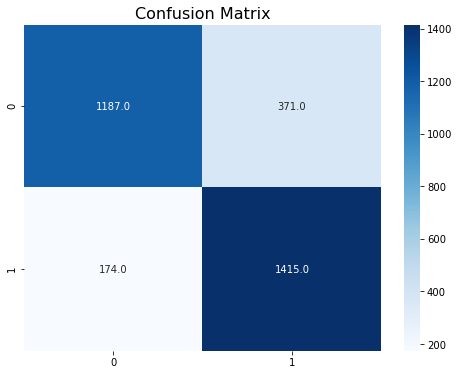

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.35, random_state=42
)

#Train
svc = SVC(kernel='linear').fit(X_train, y_train)
preds = svc.predict(X_test)

#Evaluate
print (classification_report(y_test, preds))
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}' )
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f');

As this is a classification problem aiming to predict which messages should be classified as spam, we will use the following ML models:

- K-Nearest Neighbor (KNN)
- Logistic Regression
- Random Forest
- Gradient Boost

In [15]:
# importing all models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# K-Nearest Neighbors

Accuracy = 0.5300
Recall = 0.9924
Precision = 0.5181


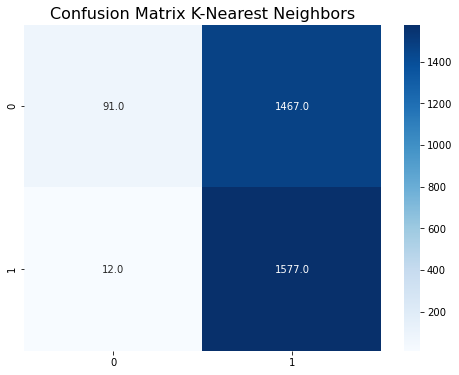

In [16]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Fit model to training data
knn.fit(X_train, y_train)

# Predict using model: 
y_pred_knn = knn.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, y_pred_knn):.4f}\nRecall = {recall_score(y_test, y_pred_knn):.4f}\nPrecision = {precision_score(y_test, y_pred_knn):.4f}' )
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix K-Nearest Neighbors', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f');

In [17]:
cv_scores_test= cross_val_score(knn,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(knn,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_test_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_knn))

[0.84865344 0.53322549 0.83786298 0.8391474  0.81997614]
Mean cross validation test score: 0.7757730900971315
Mean cross validation train score: 0.7722718222521117
Standard deviation in cv test scores: 0.12162750715793275


# Logistic Regression

Accuracy = 0.8634
Recall = 0.9830
Precision = 0.7949


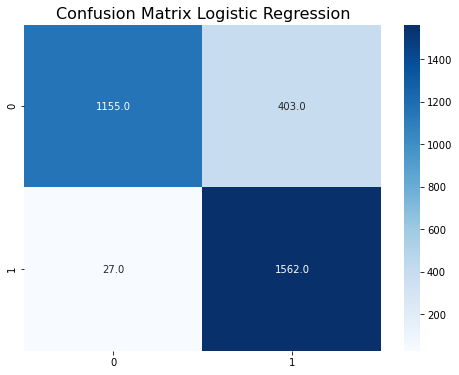

In [18]:
C_param_range = [0.001,0.01,0.1,1,10,100]

table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
table['C_parameter'] = C_param_range


j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    logreg = LogisticRegression(penalty = 'l2', C = i,random_state = 42)
    logreg.fit(X_train,y_train)
    
    # Predict using model
    y_pred_lr = logreg.predict(X_test)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
table

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, y_pred_lr):.4f}\nRecall = {recall_score(y_test, y_pred_lr):.4f}\nPrecision = {precision_score(y_test, y_pred_lr):.4f}' )
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Logistic Regression', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f');

In [19]:
cv_scores_test= cross_val_score(logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.83747581 0.86663441 0.83247391 0.86472932 0.84581084]
Mean cross validation test score: 0.8494248581472494
Mean cross validation train score: 0.9183472248910969
Standard deviation in cv test scores: 0.013954000692685454


# Random Forest

Accuracy = 0.9237
Recall = 0.91
Precision = 0.94


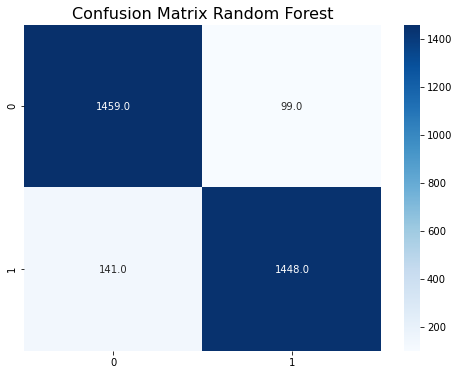

In [20]:
rf = RandomForestClassifier(random_state=42)

# Fit model to training data
rf.fit(X_train, y_train)

# Predict using model: 
y_pred_rf = rf.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, y_pred_rf):.4f}\nRecall = {recall_score(y_test, y_pred_rf):.2f}\nPrecision = {precision_score(y_test, y_pred_rf):.2f}' )
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Random Forest', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f');

In [21]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_test_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rf))

[0.94290235 0.93198678 0.92495248 0.90512447 0.92511476]
Mean cross validation test score: 0.9260161692684082
Mean cross validation train score: 0.962377859117845
Standard deviation in cv test scores: 0.012322324406938147


# Gradient Boost

Accuracy = 0.8290
Recall = 0.79
Precision = 0.86


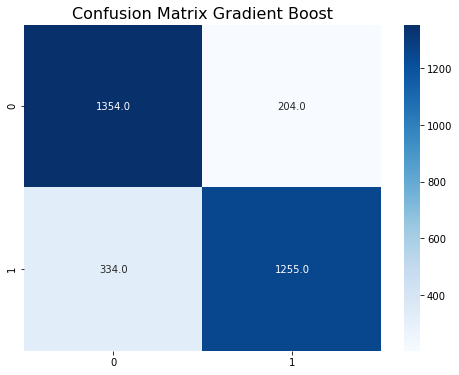

In [22]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

# Fit model to training data
gb.fit(X_train, y_train)

# Predict using model: 
y_pred_gb = gb.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, y_pred_gb):.4f}\nRecall = {recall_score(y_test, y_pred_gb):.2f}\nPrecision = {precision_score(y_test, y_pred_gb):.2f}' )
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Gradient Boost', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f');

In [23]:
cv_scores_test= cross_val_score(gb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_gb_test= cv_scores_test.mean()
cv_scores_gb_train= cv_scores_train.mean()
cv_scores_std_test_gb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gb_test))
print ('Mean cross validation train score: ' +str(cv_scores_gb_test))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_gb))

[0.8266459  0.86462869 0.837044   0.83142733 0.84774212]
Mean cross validation test score: 0.8414976084763566
Mean cross validation train score: 0.8414976084763566
Standard deviation in cv test scores: 0.013534098022247747


## Model comparison

We applied different ML models and evaluate them using ROC-AUC scores. We will now compare the cross validation test score of all models to see which one is the most accurate.

In [24]:
cv_scores_test = pd.to_numeric([cv_scores_lr_test,cv_scores_knn_test,cv_scores_rf_test,cv_scores_gb_test], downcast='float')
cv_scores_train = pd.to_numeric([cv_scores_lr_train,cv_scores_knn_train,cv_scores_rf_train,cv_scores_gb_train], downcast='float')
accuracy_scores = pd.to_numeric([accuracy_score(y_test, y_pred_lr),accuracy_score(y_test, y_pred_knn),accuracy_score(y_test, y_pred_rf),accuracy_score(y_test, y_pred_gb)], downcast='float')
cols = ['Model', 'CV test score', 'CV train score', 'Accuracy']
indexes = ['Logistic Regression', 'K-Nearest Neighbors', 'Random Forest', 'Gradient Boost']

df_scores = pd.DataFrame(np.array([indexes, cv_scores_test, cv_scores_train, accuracy_scores])).T

df_scores.columns = cols
#df_scores.set_index('Model', inplace=True)

df_scores

,Model,CV test score,CV train score,Accuracy
0,Logistic Regression,0.84942484,0.91834724,0.86336195
1,K-Nearest Neighbors,0.7757731,0.7722718,0.5300286
2,Random Forest,0.92601615,0.96237785,0.9237369
3,Gradient Boost,0.8414976,0.87610507,0.8290435


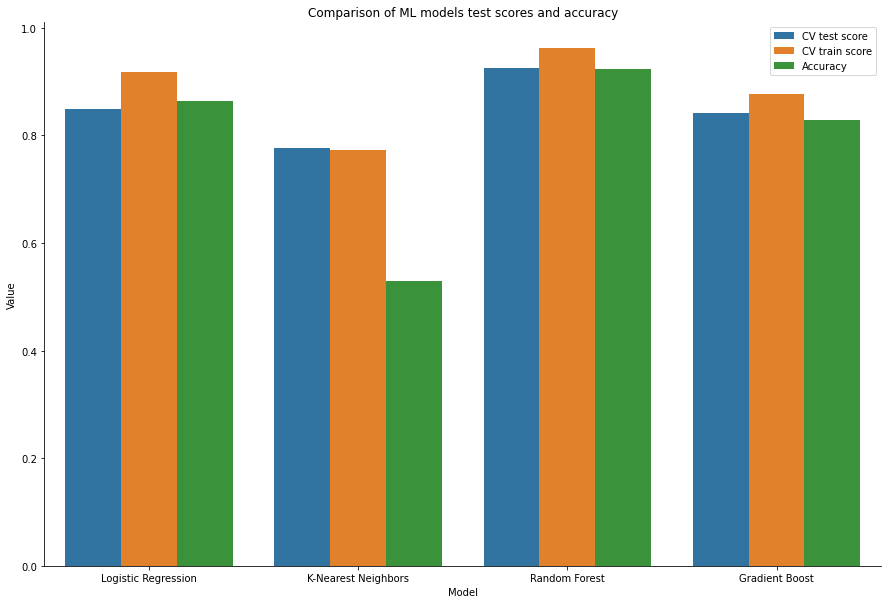

In [25]:
df_scores.explode('CV test score')
df_scores['CV test score'] = df_scores['CV test score'].astype('float')

df_scores.explode('CV train score')
df_scores['CV train score'] = df_scores['CV train score'].astype('float')

df_scores.explode('Accuracy')
df_scores['Accuracy'] = df_scores['Accuracy'].astype('float')

fig, ax1 = plt.subplots(figsize=(15, 10))
tidy = df_scores.melt(id_vars='Model').rename(columns=str.title)
tidy
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy, ax=ax1)
plt.title('Comparison of ML models test scores and accuracy')
plt.xlabel('Model')
plt.legend(loc='best')
sns.despine(fig)

From the barplot, we can see that Random Forest and Logistic Regression are the best models to use for our spam filter.

## Hyperparameter Tuning for Random Forest

In [26]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=42)

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=5)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=5)]

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# mehtod of selecting samples for training each tree
bootstrap = [True, False]

# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from pprint import pprint

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 35, 60, 85, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [27]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 150 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [28]:
# view the best parameters from fitting the random search
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=85, min_samples_split=10,
                       n_estimators=400, random_state=42)

In [29]:
base_model = RandomForestClassifier(random_state=42)
base_model.fit(X_train, y_train)
y_pred_rf = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_rf)
best_random = rf_random.best_estimator_
y_pred_rf_random = rf_random.predict(X_test)
random_accuracy = accuracy_score(y_test, y_pred_rf_random)

print('Using best hyperparameters resulted in an accuracy improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Using best hyperparameters resulted in an accuracy improvement of -2.44%.


In [30]:
rf = RandomForestClassifier(bootstrap=False, max_depth=85, min_samples_split=10,
                       n_estimators=400, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred_rf)
# recall = recall_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
cv = cross_val_score(rf, X_test, y_test,scoring='roc_auc').mean()
print(acc)
print(precision)
print(cv)

0.9011757229107086
0.9637155297532656
0.9142434584839565


##### ROC-AUC Score and the ROC curve:

In [31]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, f1_score
y_scores_rf = rf.predict_proba(X_test)
y_scores_rf = y_scores_rf[:,1]
auroc = roc_auc_score(y_test, y_scores_rf)
f1 = f1_score(y_test, y_scores_rf>0.5)
print("ROC-AUC Score:", auroc)
print("F1 score:", f1)

ROC-AUC Score: 0.9648148656803716
F1 score: 0.895180316818335


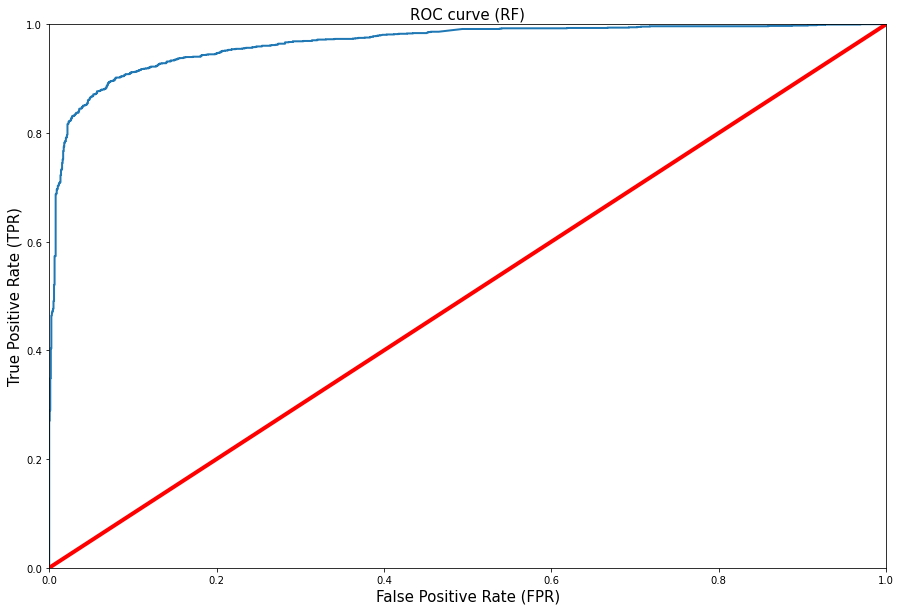

In [32]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_rf)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (RF)',fontsize=15)

plt.figure(figsize=(15, 10))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("ROC curve RF.png")
plt.show()

## Hyperparameter Tuning for Logistic Regression

In [33]:
logreg = LogisticRegression(random_state=42)

# norm of penalty
penalty = ['l1','l2', 'elasticnet']

# Inverse of regularization strength
C = [0.001,0.01,0.1,1,10,100]

# Whether a constant (a.k.a. bias or intercept) should be added to the decision function.
fit_intercept = [True, False]

#Number of CPU cores used when parallelizing over classes
n_jobs = [-1, 1, 2]

multi_class = ['auto', 'ovr', 'multinomial']

verbose = [0, 1, 5, 10]

# create the random grid
random_grid = {'penalty': penalty,
               'C': C,
               'fit_intercept': fit_intercept,
               'n_jobs': n_jobs,
               'multi_class': multi_class,
              'verbose': verbose}

from pprint import pprint

pprint(random_grid)

{'C': [0.001, 0.01, 0.1, 1, 10, 100],
 'fit_intercept': [True, False],
 'multi_class': ['auto', 'ovr', 'multinomial'],
 'n_jobs': [-1, 1, 2],
 'penalty': ['l1', 'l2', 'elasticnet'],
 'verbose': [0, 1, 5, 10]}


Random search training

In [34]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 150 different combinations, and use all available cores
logreg_random = RandomizedSearchCV(estimator = logreg, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
logreg_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'fit_intercept': [True, False],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'n_jobs': [-1, 1, 2],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'verbose': [0, 1, 5, 10]},
                   random_state=42, verbose=2)

In [35]:
# view the best parameters from fitting the random search
logreg_random.best_estimator_

LogisticRegression(C=10, fit_intercept=False, multi_class='multinomial',
                   n_jobs=-1, random_state=42, verbose=5)

In [36]:
base_model = LogisticRegression(random_state=42)
base_model.fit(X_train, y_train)
y_pred_logreg = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_logreg)
best_random = logreg_random.best_estimator_
y_pred_logreg_random = logreg_random.predict(X_test)
random_accuracy = accuracy_score(y_test, y_pred_logreg_random)

print('Using best hyperparameters resulted in an accuracy improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Using best hyperparameters resulted in an accuracy improvement of 10.38%.


In [ ]:
logreg = RandomForestClassifier(bootstrap=False, max_depth=32, max_features='sqrt',
                       n_estimators=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred_logreg)
# recall = recall_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_logreg)
cv = cross_val_score(logreg, X_test, y_test,scoring='roc_auc').mean()
print(acc)
print(precision)
print(cv)

##### ROC-AUC Score and the ROC curve:

In [ ]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, f1_score
y_scores_logreg = logreg.predict_proba(X_test)
y_scores_logreg = y_scores_logreg[:,1]
auroc = roc_auc_score(y_test, y_scores_logreg)
f1 = f1_score(y_test, y_scores_logreg>0.5)
print("ROC-AUC Score:", auroc)
print("F1 score:", f1)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_logreg)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (RF)',fontsize=15)

plt.figure(figsize=(15, 10))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("ROC curve RF.png")
plt.show()